In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

from simulation_code.tissue_model import invision_source
from simulation_code.load_model import load_model_from_excel
from simulation_code.utils import simulate_acoustic
from simulation_code.tissues import melanin_absorber

from jwave.geometry import Domain, Medium, TimeAxis

from itertools import product

os.environ["PA_SIM_EXTRAPOLATE"] = "0"

In [2]:
dx = 0.1  # mm
nx, ny, nz = 220, 220, 220

FAST_DEMO_MODE = True

# Wavelengths to get reflectance measurements at.
WAVELENGTHS = np.arange(700, 920, 20)
if FAST_DEMO_MODE:
    WAVELENGTHS = WAVELENGTHS[:1]

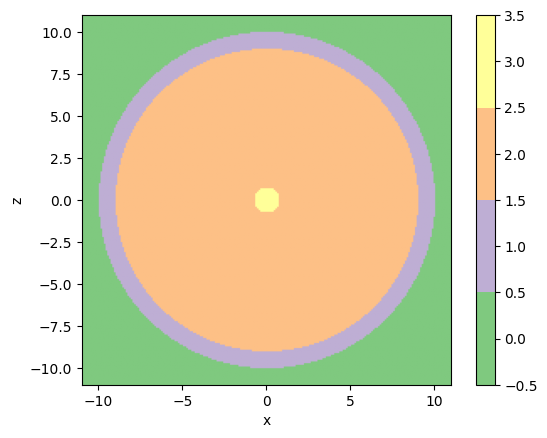

In [3]:
tissue_model_example = load_model_from_excel(
    "simulation_specification/invision_phantom_specification.xlsx", nx, ny, nz, dx
)
tissue_model_example.imshow()
plt.show()

In [4]:
artery_oxygenation = [1]
absorptions = [0.00123, 0.447, 0.793, 1.18, 1.84]  # From DIS measurements
mvfs = [x / melanin_absorber(1)(685)[()] for x in absorptions]
if FAST_DEMO_MODE:
    mvfs = mvfs[-1:]
c = 1500
fs = 4e7
domain = Domain((256, 256, 256), (0.1 * 4e-3, 0.1 * 4e-3, 0.1 * 4e-3))
medium = Medium(domain=domain, sound_speed=c)
time_axis = TimeAxis(1 / fs, 0.08 / medium.sound_speed)

In [5]:
def run_simulations_all(
    p0_data, p0_all, domain: Domain, medium: Medium, time_axis: TimeAxis, geometry
):
    results = []
    for p0 in tqdm(p0_all, desc=" wavelength loop", position=1, leave=False):
        sd = simulate_acoustic(
            p0_data,
            p0,
            domain,
            medium,
            time_axis,
            geometry)
        results.append(sd.T)
    return np.stack(results)

Running simulations for [1] [0.010670197306807844]


  0%|          | 0/1 [00:00<?, ?it/s]

###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2022 Qianqian Fang <q.fang at neu.edu>          #
#                             http://mcx.space/                               #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
$Rev::      $v2022.10$Date::                       $ by $Author::             $
###############################################################################
- variant name: [Fermi] compiled by nvcc

 wavelength loop:   0%|          | 0/1 [00:00<?, ?it/s]

[100.0, 100.0, 100.0] [155.0, 155.0, 155.0]
(220, 220, 220) (55, 55, 55) (256, 256, 256)


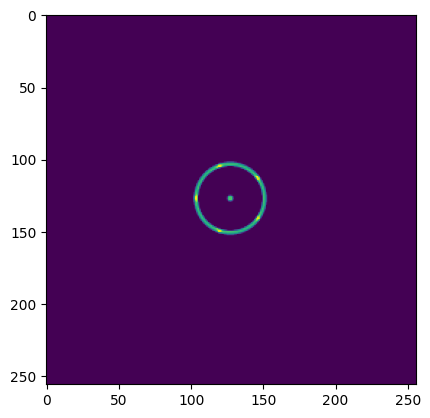

In [6]:
print("Running simulations for", artery_oxygenation, mvfs)

for i, (ox, mvf) in enumerate(tqdm(list(product(artery_oxygenation, mvfs)))):
    settings = {"mvf": mvf, "artery_oxygenation": ox}

    tissue_model = load_model_from_excel(
        "simulation_specification/invision_phantom_specification.xlsx",
        nx,
        ny,
        nz,
        dx,
        variations=[("Epidermis", {"MelanosomeVolumeFraction": mvf})],
    )

    m = tissue_model.run_mcx(
        WAVELENGTHS,
        [invision_source(tissue_model, i) for i in range(10)],
        middle_slice_only=False,
        gpu_device=2,
    )
    # m["p0"] = p
    m.update(settings)
    geometry = np.load("../data/invision_geometry.npz")["geom"]
    geometry[:, 2] = geometry[:, 1]
    geometry[:, 1] = 0
    p0_data = dict(
        geom=geometry,
        dx_mm=tissue_model.dx_mm,
        r0=tissue_model.r_0,
        n=np.array(tissue_model.n),
    )
    p0_data.update(m)
    p0_raw = p0_data["p0"]

    time_series = run_simulations_all(
        p0_data, p0_raw, domain, medium, time_axis, geometry
    )
    if not FAST_DEMO_MODE:
        np.savez(
            f"../data/simulations/acoustic_invision_{i}",
            ts=time_series,
            geometry=geometry,
            fs=fs,
            c=c,
            wavelength=p0_data["wavelength"],
            artery_ox=ox,
            mvf=mvf,
            mua=m["mua"][0, :, m["mua"].shape[2] // 2],
            p0=m["p0"][0, :, m["p0"].shape[2] // 2],
            seg=m["seg"][0, :, m["seg"].shape[2] // 2],
        )
    else:
        np.savez(
            f"../data/simulations/demo_acoustic_invision_{i}",
            ts=time_series,
            geometry=geometry,
            fs=fs,
            c=c,
            wavelength=p0_data["wavelength"],
            artery_ox=ox,
            mvf=mvf,
            mua=m["mua"][0, :, m["mua"].shape[2] // 2],
            p0=m["p0"][0, :, m["p0"].shape[2] // 2],
            seg=m["seg"][0, :, m["seg"].shape[2] // 2],
        )

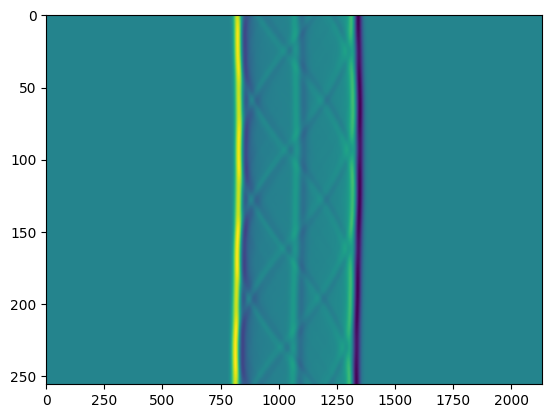

In [7]:
plt.imshow(time_series[0], aspect="auto")
plt.show()